In marketing, churn refers to the behavior of the customer intent on
terminating his or her relationship with the company. There are different types of churn, in which it is clearly identifiable or in the non-subscription business in which the churn is not recognizable. Furthermore, the churn can be driven or not by a marketing campaign, it can be voluntary or non-voluntary. It is not easy to identify the churn.

Initially I import the libraries and the data I need.

In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import numpy as np
import csv
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
drive.mount('/content/gdrive')
data=pd.read_csv("/content/gdrive/MyDrive/customer_orders.csv")





Mounted at /content/gdrive


These are the columns in the dataset:

In [ ]:
data.columns

Index(['order_id', 'customer_id', 'store_id', 'product_id', 'direction',
       'gross_price', 'price_reduction', 'purchase_datetime', 'product_class',
       'address_id', 'birthdate', 'gender', 'job_type', 'email_provider',
       'flag_phone_provided', 'flag_privacy', 'postal_code', 'district',
       'region', 'account_id', 'favorite_store', 'loyalty_type',
       'loyatlty_status', 'activation_date', 'loyalty_status'],
      dtype='object')

I determine the first and the last purchase date for each customer

In [ ]:
# date first purchase
final=data
data_min = final.groupby('customer_id')['purchase_datetime'].min().reset_index()
data_min.columns = ['customer_id', 'PRIMA_DATA']

# date last purchase
data_max = final.groupby('customer_id')['purchase_datetime'].max().reset_index()
data_max.columns = ['customer_id', 'ULTIMA_DATA']

Once I have computed this calculation for each customer, I evaluate the difference between these two dates, I delete the customers that have made purchase only in a single day.

In [ ]:
# I join the previous tables in order to determine the difference between the two dates
diff_date_acquisto = pd.merge(data_min, data_max, on='customer_id')
diff_date_acquisto['ULTIMA_DATA']=pd.to_datetime(diff_date_acquisto['ULTIMA_DATA'])
diff_date_acquisto['PRIMA_DATA']=pd.to_datetime(diff_date_acquisto['PRIMA_DATA'])
diff_date_acquisto['DIFF_IN_DAYS'] = (diff_date_acquisto['ULTIMA_DATA'] - diff_date_acquisto['PRIMA_DATA']).dt.days

#I delete the differences equal to 0
diff_date_acquisto = diff_date_acquisto[diff_date_acquisto['DIFF_IN_DAYS'] != 0]


As explained before, it is not easy to identify the churners.
To determine after how many days from the last purchase a customer can be define churner I use the repurchase curve determined in  the RFM analysis.
In fact, from the previous model, I discover that above the 90% of the customer repurchase after 82 days. I choose as reference date :2023-02-07. The customers that did not purchase in the 82 days before this date are classified as churners.


In [ ]:
from datetime import datetime, timedelta
# I assign the value 0[NON CHURNERS] for the ones that have made a purchase at the most 82 days before 2023-02-07(reference date), 1(CHURNERS) otherwise.
last_82 = diff_date_acquisto[diff_date_acquisto['ULTIMA_DATA'] <= datetime.strptime('2023-02-07', '%Y-%m-%d')-timedelta(days=82)].copy()
last_82['CHURN'] = 1

# I join last_82 and diff_date_acquisto and after I assign the value 1 for churners
diff_date_acquisto = pd.merge(diff_date_acquisto, last_82, how='outer')
diff_date_acquisto['CHURN'] = diff_date_acquisto['CHURN'].fillna(0)

diff_date_acquisto = diff_date_acquisto[['customer_id', 'CHURN']]


In [ ]:
diff_date_acquisto

,customer_id,CHURN
0,23,0.0
1,30,1.0
2,32,0.0
3,48,0.0
4,50,0.0
...,...,...
68959,928567,0.0
68960,928707,0.0
68961,928777,0.0
68962,929438,0.0


In [ ]:
# Trasformation columns for the models

# net price for each order
total_acquired_product = data.copy()
total_acquired_product['gross_price'] = pd.to_numeric(total_acquired_product['gross_price'])
total_acquired_product['price_reduction'] = pd.to_numeric(total_acquired_product['price_reduction'])
total_acquired_product['net_price'] = total_acquired_product['gross_price'] - total_acquired_product['price_reduction']

# convert direction to numeric
total_acquired_product['direction'] = pd.to_numeric(total_acquired_product['direction'])

# I sum the total expenditure per costumers and I count the number of products he/she purchases
exp_tot_cust= total_acquired_product.groupby('customer_id').agg({'net_price': 'sum', 'direction': 'sum'}).reset_index()
exp_tot_cust.columns = ['customer_id', 'total_expenditure', 'number of articles']

# I add these columns to the informations about the client

total_info_clients= data[['customer_id','address_id','birthdate','gender','job_type',
       'email_provider','flag_phone_provided','flag_privacy','postal_code',
       'region','account_id','favorite_store','loyalty_type',
       'loyatlty_status','activation_date']]
total_info_clients=total_info_clients.drop_duplicates(subset="customer_id",keep="first")
total_info_clients = pd.merge(total_info_clients, exp_tot_cust,on=["customer_id"])
total_info_clients = pd.merge(total_info_clients, diff_date_acquisto,on=['customer_id'])

# I drop the costumers that have an expenditure equals to Nan
total_info_clients = total_info_clients.dropna(subset=['total_expenditure'])


In [ ]:
total_info_clients.CHURN.value_counts(normalize=True)

0.0    0.739226
1.0    0.260774
Name: CHURN, dtype: float64

The classes are not  balanced between churners and non-churners. The churners are the minority(26%). This means that there is the need of actions to rebalance the dataset in order to make a correct  classification procedure

I convert some variables in factor, and after I apply the one-hot encoding technique. This is necessary in order to use the classification models.

In [ ]:
# I select the variables of interest for the churn model
churn = total_info_clients[['job_type', 'flag_phone_provided', 'email_provider', 'favorite_store','loyalty_type',
                            'loyatlty_status', 'region', 'flag_privacy', 'total_expenditure',
                            'number of articles', 'CHURN']]

#Conversione delle variabili in fattori
churn['flag_phone_provided'] = churn['flag_phone_provided'].astype('category')
churn['favorite_store'] = churn['favorite_store'].astype('category')
churn['loyalty_type'] = churn['loyalty_type'].astype('category')
churn['loyatlty_status'] = churn['loyatlty_status'].astype('category')
churn['region'] = churn['region'].astype('category')
churn['flag_privacy'] = churn['flag_privacy'].astype('category')
churn['CHURN'] = churn['CHURN'].astype('category')
# one-hot encoding
df_encoded = pd.get_dummies(churn, columns=['job_type', 'email_provider', 'region','loyalty_type'], prefix=['job_type', 'email_provider','region','loyalty_type'])

I choose the most releveant features in order to make the classification.
The provided code performs feature importance analysis using the ExtraTreesClassifier algorithm from the scikit-learn library.

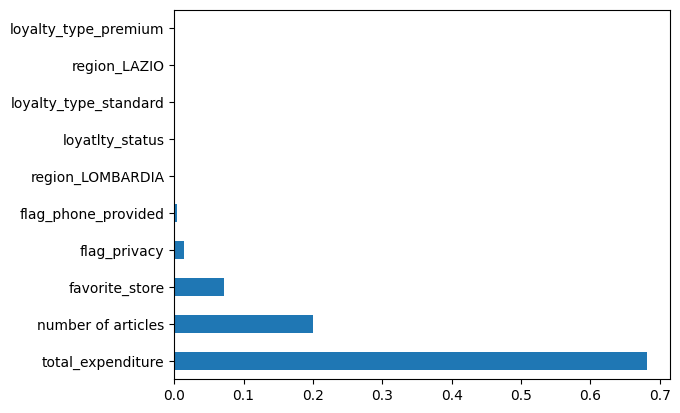

In [ ]:
import matplotlib.pyplot as plt
X = df_encoded.drop('CHURN',axis=1)  #independent columns
y = df_encoded['CHURN']   #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

From the results we can see that the most relevant variables are:total expenditure,number of articles, favorite_store and flag_privacy. I select only these for the classification task.

As previously show the dataset presents unabalanced classes. They are required some actions:

In [ ]:
new=df_encoded[['CHURN','total_expenditure','favorite_store','number of articles']]

class_0 = new[new['CHURN'] == 0]
class_1 = new[new['CHURN'] == 1]
count_class_0 = len(class_0)
count_class_1 = len(class_1)
class_1_oversampled = class_1.sample(n=count_class_0, replace=True, random_state=123)
df_balanced = pd.concat([class_0, class_1_oversampled])

I divide the dataset into train and test set after an oversampling procedure in order to rebalance the classes. In this way, I can train and  test the models performance's on two different sets.I fix the seed for the reproducibility. The goal is to predict in an efficient way the class(CHURN/NOT-CHURN) of the customers.

In [ ]:
# Missing values control
df_balanced.dropna(inplace=True)



In [ ]:
df_balanced.CHURN.value_counts(normalize=True)


0.0    0.5
1.0    0.5
Name: CHURN, dtype: float64

As we can see after the oversampling procedure the dataset is balanced. Both the classes are equally represented.

In the following code I divide the data into train and  test set. I fix the seed for reproducibility.

In [ ]:
# Train-test
X = df_balanced.drop('CHURN', axis=1)
y = df_balanced['CHURN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In order to have a complete view concerning the model's performance I consider different metrics in the evaluation of the models activity. In fact, in addition to the accuracy I take into account also precision, recall,f-score, and the AUC. The metrics are calculated as follows:
* Accuracy={TP+TN}/{TP+TN+FP+FN}
* Precision={TP}/{TP+FP}
* Recall={TP}/{TP+FN}
* F-score={2 x precision x recall}/{precision+recall}
where in this specific case the class Positive represents the churners while the class Negative indicates the non-churners.


The first algorithm that I use is the Random Forest. It is based on a combination of randomly generated and independently trained decision trees with the use of bootstraping techniques.


In [ ]:
# Random Forest
rfModel = RandomForestClassifier(n_estimators=250, random_state=123)
rfModel.fit(X_train, y_train)
y_pred_rf = rfModel.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print('Random Forest Accuracy:', accuracy_rf)
print('Random Forest Precision:', precision_rf)
print('Random Forest Recall:', recall_rf)
print('Random Forest F1-score:', f1_rf)



Random Forest Accuracy: 0.833709297763829
Random Forest Precision: 0.7791819088792816
Random Forest Recall: 0.927278124072425
Random Forest F1-score: 0.8468037045403208


The Random Forest model identifies the 92% of the churners. In 83% of the cases the model correctly assign a customer to one of the two classes.

In [ ]:
dat=X_test.copy()

I create a version of the dataset that contains the informations about the churners as the number of articles he purchased, his favorite store and the total_expenditure.

In [ ]:
dat['CHURN']=y_pred_rf

In [ ]:
dat

,total_expenditure,favorite_store,number of articles,CHURN
29144,688.39,49,5,1.0
11030,109.01,4,18,1.0
27053,57.00,10,4,0.0
26309,638.70,1,7,1.0
28709,94.28,38,3,1.0
...,...,...,...,...
35240,92.50,45,6,1.0
37794,77.85,37,5,0.0
53397,19.95,25,4,1.0
7606,23.89,28,3,1.0


I compute the average expenditure value for churners and non-churners.

In [ ]:
dat.groupby('CHURN').agg({'total_expenditure': 'mean'}).reset_index()


,CHURN,total_expenditure
0,0.0,239.698266
1,1.0,184.540270


As we can see the churners have, on average, a total expenditure that is 185 euro, lower than the average expense of the non-churners that is equal to 239 euro.

In [ ]:
dat.groupby('CHURN').agg({'number of articles': 'mean'}).reset_index()


,CHURN,number of articles
0,0.0,13.303085
1,1.0,7.944879


As regards the number of articles, in average the churners have purchased 8 articles.

I evaluate the churners  favorite stores.

In [ ]:
favori_per_churn = dat[dat['CHURN'] == 1]['favorite_store'].value_counts()
s=favori_per_churn.head(10)

In [ ]:
s

1     818
38    409
33    361
39    333
20    331
3     328
34    320
37    319
40    311
47    310
Name: favorite_store, dtype: int64

The store "1" is the most preferred by the one that have interrupted the relation with the company.

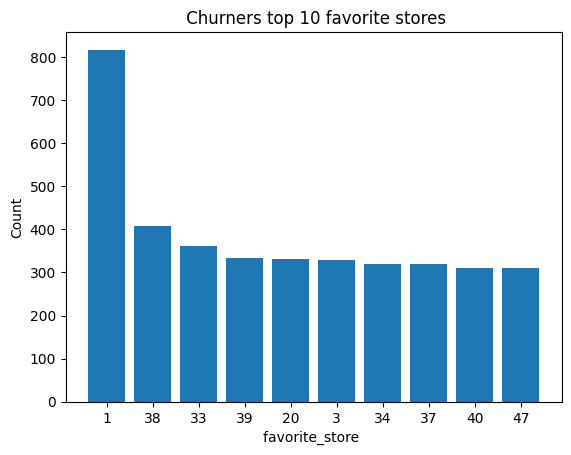

In [ ]:

favori_per_churn = dat[dat['CHURN'] == 1]['favorite_store'].value_counts().head(10)

# Creazione del barplot
plt.bar(favori_per_churn.index.astype(str), favori_per_churn.values)

# Personalizzazione dell'asse x
plt.xlabel('favorite_store ')


# Personalizzazione dell'asse y
plt.ylabel('Count')

# Titolo del grafico
plt.title(' Churners top 10 favorite stores')

# Mostrare il grafico
plt.show()


The second algorithm that I use is the Decision Tree, based on a recursive partition of the data driven by maximizing the polarization of the target value within each split.


In [ ]:
# Decision Tree
tree = DecisionTreeClassifier(min_samples_split=5, ccp_alpha=0.000001, random_state=123)
tree.fit(X_train, y_train)
y_pred_dt = tree.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print('Decision Tree Accuracy:', accuracy_dt)
print('Decision Tree Precision:', precision_dt)
print('Decision Tree Recall:', recall_dt)
print('Decision Tree F1-score:', f1_dt)

Decision Tree Accuracy: 0.7868772067477442
Decision Tree Precision: 0.7566146993318486
Decision Tree Recall: 0.8403086969427129
Decision Tree F1-score: 0.7962685167822989


It obtains lower performances than the Random Forest algorithm, in fact the Decision tree provides a correct classification of the customers into the 78% of the cases. Furthermore, as explained by the Precision, in the  75% of the cases, a customer that is classified as a churner, it turns out to be
a churner.

The third algorithm is the Logistic Regression that use the logistic function
in order to classify the instances.

In [ ]:
# Logistic Regression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print('Logistic Regression Accuracy:', accuracy_lr)
print('Logistic Regression Precision:', precision_lr)
print('Logistic Regression Recall:', recall_lr)
print('Logistic Regression F1-score:', f1_lr)

Logistic Regression Accuracy: 0.5813063946645743
Logistic Regression Precision: 0.5588477983647139
Logistic Regression Recall: 0.7371128920550114
Logistic Regression F1-score: 0.6357197713115453


In this case the performance metrics have lower values than the two previous algorithm. The Logistic regression recognizes about the 73% of the churners.
In the 58% of the cases, the algorithm provides a correct classification.

The fourth algorithm is the MultiLayer Perceptron,the variables in the input layer are combined into new variables using  linear combinations
and nonlinear activation functions:tanh, sigmoid ecc... At the end there is an estimate for the target through the softmax function.


In [ ]:
# Multilayer Perceptron
mlp = MLPClassifier(hidden_layer_sizes=(5,), alpha=1e-5, random_state=123)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print('Multilayer Perceptron Accuracy:', accuracy_mlp)
print('Multilayer Perceptron Precision:', precision_mlp)
print('Multilayer Perceptron Recall:', recall_mlp)
print('Multilayer Perceptron F1-score:', f1_mlp)

Multilayer Perceptron Accuracy: 0.5821890937622597
Multilayer Perceptron Precision: 0.5673085079311222
Multilayer Perceptron Recall: 0.6617196002770357
Multilayer Perceptron F1-score: 0.6108878333942271


The performances of the MLP are very similar to those of the Logistic Regression, in fact the classifier is capable of identify the 58% of the churners, and it makes a correct classification for the 66% of the instances.

I take into account the Roc curve of the four classifier
The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model. It illustrates the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) as the classification threshold is varied.
The performances can be evaluated through the AUC(Area Under the Curve).

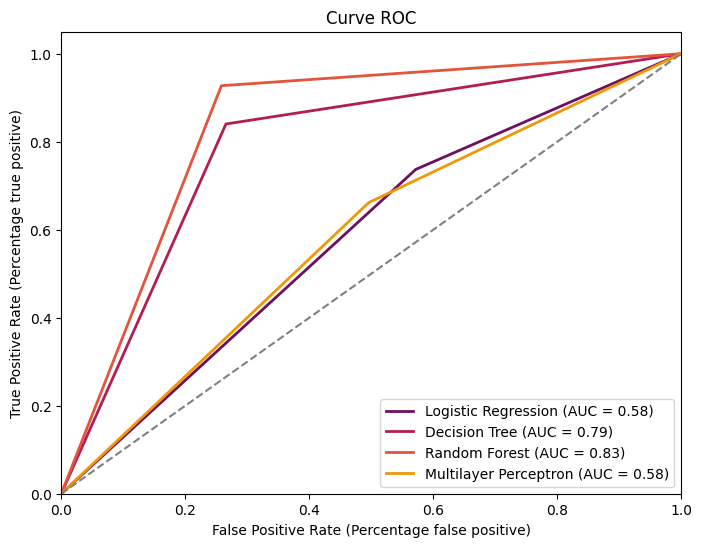

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Roc curves calculation
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp)

# Auc calculation
auc_logreg = roc_auc_score(y_test, y_pred_lr)
auc_dt = roc_auc_score(y_test, y_pred_dt)
auc_rf = roc_auc_score(y_test, y_pred_rf)
auc_mlp = roc_auc_score(y_test, y_pred_mlp)

# Roc curve plots
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='#6c0f5e', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(auc_logreg))
plt.plot(fpr_dt, tpr_dt, color='#b31d56', lw=2, label='Decision Tree (AUC = {:.2f})'.format(auc_dt))
plt.plot(fpr_rf, tpr_rf, color='#e2543b', lw=2, label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_mlp, tpr_mlp, color='#f09708', lw=2, label='Multilayer Perceptron (AUC = {:.2f})'.format(auc_mlp))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Percentage false positive)')
plt.ylabel('True Positive Rate (Percentage true positive)')
plt.title('Curve ROC')
plt.legend(loc='lower right')
plt.show()


As previously noted, the two classifiers that obtain the best result are the Decision Tree and the Random Forest classifier. As regards the AUC, in both cases the value is about 0.8.